In [45]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List, TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
import json
from langgraph.types import interrupt, Command

In [46]:
from dotenv import load_dotenv
load_dotenv()

True

In [47]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[List[BaseMessage], add_messages]
    current_score: float

In [48]:
# Initialize the LLM.
# Ensure you have authenticated your gcloud CLI using 'gcloud auth application-default login'
# and set a quota project using 'gcloud auth application-default set-quota-project YOUR_PROJECT_ID'.
# Using 'gemini-pro' as a stable and widely available model.
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.0) # Lower temperature for more consistent output

In [37]:
# Define the chatbot node function.
# This function will interact with the LLM to get grammar corrections and scores.
def chatbot(state: State) -> State | Literal[END]:
    """
    Processes the user's message, sends it to the LLM for grammar correction and scoring,
    and updates the state with the corrected output and score.
    """
    # Get the content of the last human message from the state.
    # We assume the last message added to the 'messages' list is the user's input.
    user_message = state["messages"][-1].content

    # Construct a detailed prompt for the LLM.
    # The prompt instructs the LLM to return a JSON object with specific keys:
    # 'corrected_sentence' and 'score'. This makes parsing the response reliable.
    prompt = f"""You are a highly accurate grammar correction and scoring assistant.
    Your task is to:
    1. Grammatically correct the provided sentence, ensuring it is natural and fluent.
    2. Assign a grammatical score to the *corrected* sentence. The score must be a float between 0.0 and 1.0, where 1.0 indicates perfect grammatical correctness and 0.0 indicates completely incorrect grammar. The score should reflect the grammatical quality of the *output* sentence.
    3. Make only one correction at once in one iteartion.

    Respond ONLY with a JSON object. Do not include any other text or explanation.
    The JSON object must have the following two keys:
    - `corrected_sentence`: The grammatically corrected version of the input sentence.
    - `score`: A float (e.g., 0.95, 1.0) representing the grammatical score of the corrected sentence.

    Example Input: 'He go to school.'
    Example Output:
    {{
    "corrected_sentence": "He goes to school.",
    "score": 0.98
    }}

    Example Input: 'The cat sits on the mat.'
    Example Output:
    {{
    "corrected_sentence": "The cat sits on the mat.",
    "score": 1.0
    }}

    Input sentence to correct and score: '{user_message}'
    Don't include the json formatting that is 
    ```json
    ```"""

    # Invoke the LLM with the crafted prompt.
    try:
        raw_response = llm.invoke(prompt).content
        # Attempt to parse the LLM's response as a JSON object.
        response_data = json.loads(raw_response)
        
        # Extract the corrected sentence and score from the parsed JSON.
        # Provide fallback values in case keys are missing (though the prompt aims to prevent this).
        corrected_sentence = response_data.get("corrected_sentence", user_message)
        score = float(response_data.get("score", 0.0)) # Ensure score is a float
    except json.JSONDecodeError:
        # Handle cases where the LLM does not return valid JSON.
        print(f"Warning: Could not parse LLM response as JSON. Raw response: {raw_response}")
        corrected_sentence = f"Error: Could not process grammar. Original input: '{user_message}'. Please try rephrasing."
        score = 0.0 # Set score to 0 to ensure re-processing if JSON parsing fails
    except Exception as e:
        # Handle any other unexpected errors during LLM invocation or data extraction.
        print(f"An unexpected error occurred during LLM invocation: {e}")
        corrected_sentence = f"Error: An unexpected error occurred. Original input: '{user_message}'. Please try again."
        score = 0.0

    # Format the output string as requested by the user.
    formatted_output = f"Output: {corrected_sentence}\nScore: {score:.2f}" # Format score to 2 decimal places

    # Return the updated state.
    # 'messages' is updated with the AIMessage containing the formatted output.
    # 'current_score' is updated with the score extracted from the LLM's response.
    print(state)
    return {
        "messages": [AIMessage(content=corrected_sentence)],
        "current_score": score
    }


In [38]:
# Define the conditional function that determines the next step in the graph.
def should_continue(state: State) -> Literal["chatbot"] | Literal[END]:
    """
    Checks the current_score in the state.
    If the score is 0.95 or higher, the process ends.
    Otherwise, it loops back to the 'chatbot' node for another attempt.
    """
    score = state.get("current_score", 0.0) # Get the current score, defaulting to 0.0 if not found
    
    # Define the threshold for stopping the loop.
    score_threshold = 0.95
    

    if score >= score_threshold:
        print(f"Grammatical score {score:.2f} >= {score_threshold}. Ending process.")
        return END # End the graph execution
    else:
        print(f"Grammatical score {score:.2f} < {score_threshold}. Re-processing...")
        return "chatbot" # Loop back to the chatbot node

In [39]:
# Build the LangGraph.
builder = StateGraph(State)

# Add the 'chatbot' node to the graph.
builder.add_node("chatbot", chatbot)

# Set the entry point of the graph to the 'chatbot' node.
builder.add_edge(START, "chatbot")

# Add a conditional edge from the 'chatbot' node.
# The 'should_continue' function will be called after 'chatbot' executes.
# Its return value ('chatbot' or END) will dictate the next transition.
builder.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "chatbot": "chatbot", # If should_continue returns "chatbot", transition to "chatbot" node
        END: END              # If should_continue returns END, terminate the graph
    }
)

In [40]:
# Compile the graph into an executable application.
app = builder.compile()

# --- Example Usage ---
# You can test the chatbot by streaming inputs through the compiled app.

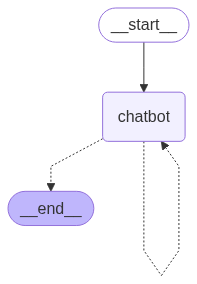

In [41]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
# --- Example Usage ---
# You can test the chatbot by streaming inputs through the compiled app.

# Example 1: Sentence that might need correction and iterative improvement
# Example 1: Sentence that might need correction and iterative improvement
print("--- Testing with 'He go a to school..' ---")
inputs1 = {"messages": [HumanMessage(content="He was is a kitten.")]}
for s in app.stream(inputs1):
    print(s)




--- Testing with 'He go a to school..' ---
{'messages': [HumanMessage(content='He was is a kitten.', additional_kwargs={}, response_metadata={}, id='4523cd1a-e011-41b8-aa0b-cc5b56b4274a')]}
Grammatical score 1.00 >= 0.95. Ending process.
{'chatbot': {'messages': [AIMessage(content='He is a kitten.', additional_kwargs={}, response_metadata={}, id='addd2d50-2b72-47b9-82e6-0d4f014216ad')], 'current_score': 1.0}}


In [49]:
inputs1 = {"messages": [HumanMessage(content="Me walk to store, buy apple. Then I seen cat, it was black. Cat run fast, I chasing. My friend come, we laugh loud. Them was good time.")]}
for s in app.stream(inputs1):
    print(s['chatbot']['messages'][0].content, s['chatbot']['current_score'])


{'messages': [HumanMessage(content='Me walk to store, buy apple. Then I seen cat, it was black. Cat run fast, I chasing. My friend come, we laugh loud. Them was good time.', additional_kwargs={}, response_metadata={}, id='5b9c647b-7d6b-4987-b43b-46df8161ae63')]}
Grammatical score 0.15 < 0.95. Re-processing...
I walk to store, buy apple. Then I seen cat, it was black. Cat run fast, I chasing. My friend come, we laugh loud. Them was good time. 0.15
{'messages': [HumanMessage(content='Me walk to store, buy apple. Then I seen cat, it was black. Cat run fast, I chasing. My friend come, we laugh loud. Them was good time.', additional_kwargs={}, response_metadata={}, id='5b9c647b-7d6b-4987-b43b-46df8161ae63'), AIMessage(content='I walk to store, buy apple. Then I seen cat, it was black. Cat run fast, I chasing. My friend come, we laugh loud. Them was good time.', additional_kwargs={}, response_metadata={}, id='7fa3cb0f-1a54-43d7-8cfb-231c7f868cb1')], 'current_score': 0.15}
Grammatical score 0